In [12]:
# libraries
import pandas as pd
import numpy as np
import nltk
# from nltk.corpus import stopwords
from nltk.stem.wordnet import WordNetLemmatizer
from nltk.tag import pos_tag
import string
import spacy
import en_core_web_sm
import re
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
nlp = en_core_web_sm.load()

# python3 -m spacy download en

# download stopwords and wordnet and punctuations

# nltk.download("stopwords")
# nltk.download("wordnet")
nltk.download("punkt")

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/himani/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package wordnet to /Users/himani/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

In [26]:
## read raw file

raw_file = pd.read_csv("LabelledData (1).txt", sep = ",,,", header = None)
raw_file.columns = ['questions','labels']
raw_file.head()

/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:3: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  This is separate from the ipykernel package so we can avoid doing imports until


questions    labels
0  how did serfdom develop in and then leave russ...   unknown
1  what films featured the character popeye doyle ?       what
2  how can i find a list of celebrities ' real na...   unknown
3  what fowl grabs the spotlight after the chines...      what
4                   what is the full form of .com ?       what

Text(0,0.5,'Frequency')

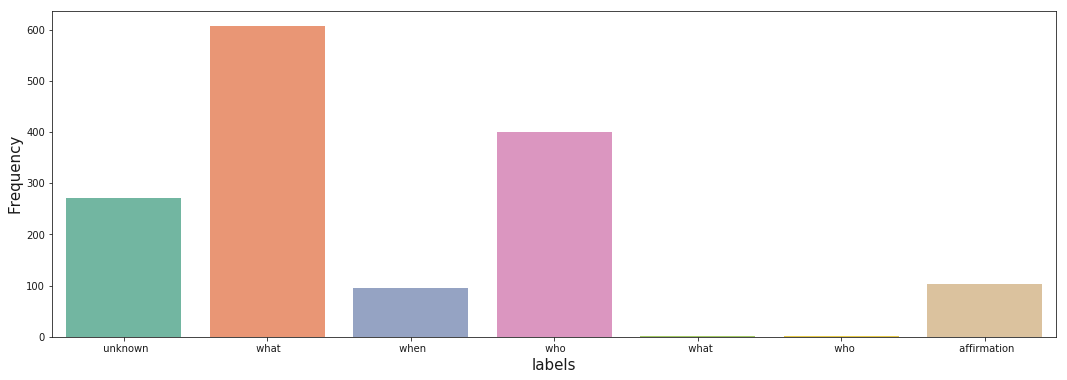

In [25]:
### distribution of levels in labels in training set

sns.set_color_codes()

fig, ax1 = plt.subplots(1,1, figsize = (18,6))

sns.countplot('labels', data = raw_file,palette="Set2", ax = ax1)
ax1.set_xlabel("labels", size = 15)
ax1.set_ylabel("Frequency", size = 15)

In [34]:
## clean questions

lemma = WordNetLemmatizer()
def clean_tokenize(document):
    document = re.sub('[^\w_\s-]', ' ',document)       #remove punctuation marks and other symbols
    tokens = nltk.word_tokenize(document)              #Tokenize sentences
    cleaned_article = " ".join(lemma.lemmatize(item) for item in tokens)
    return cleaned_article

raw_file['clean_ques'] = raw_file['questions'].apply(clean_tokenize)
raw_file.head()

questions    labels  \
0  how did serfdom develop in and then leave russ...   unknown   
1  what films featured the character popeye doyle ?       what   
2  how can i find a list of celebrities ' real na...   unknown   
3  what fowl grabs the spotlight after the chines...      what   
4                   what is the full form of .com ?       what   

                                          clean_ques  
0   how did serfdom develop in and then leave russia  
1      what film featured the character popeye doyle  
2       how can i find a list of celebrity real name  
3  what fowl grab the spotlight after the chinese...  
4                       what is the full form of com

### Create features from questions
- WH-word
- WH word POS
- pos of word next to WH word
- Root POS: The part of speech of the word at the root of the dependency parse tree.

In [37]:
raw_file['clean_ques'][0]

'how did serfdom develop in and then leave russia'

In [41]:
nlp = en_core_web_sm.load()

In [59]:
x = nlp(raw_file['clean_ques'][1])

In [60]:
list(x.sents)

[what film featured the character popeye doyle]

In [61]:
tags = {w.pos: w.pos_ for w in x}
tags

{83: 'ADJ', 89: 'DET', 91: 'NOUN', 99: 'VERB'}

In [62]:
for word in list(x.sents)[0]:
    print(word, word.pos_)

what ADJ
film NOUN
featured VERB
the DET
character NOUN
popeye NOUN
doyle NOUN


In [96]:
pos_list = []
def pos_question(row):
    
    # get linguistic annotations of question
    en_row = nlp(u''+ row)
    sent_list = list(en_row.sents)
    wh_bi_gram = []
    root_token = ""
    wh_pos = ""
    wh_nbor_pos = ""
    wh_word = ""
    
    for token in sent_list[0]:
        if token.tag_ == "WDT" or token.tag_ == "WP" or token.tag_ == "WP$" or token.tag_ == "WRB":
            wh_pos = token.tag_
            wh_word = token.text
            wh_bi_gram.append(token.text)
            try:
                wh_bi_gram.append(str(en_row[token.i + 1]))
                wh_nbor_pos = en_row[token.i + 1].tag_
            except IndexError:
                wh_bi_gram.append(str(en_row[token.i]))
                wh_nbor_pos = en_row[token.i].tag_
        if token.dep_ == "ROOT":
            root_token = token.tag_
    pos_list.append({'wh_pos':wh_pos, 'wh_word': wh_word, 'wh_bi_gram':wh_bi_gram,
                         'wh_nbor_pos':wh_nbor_pos, 'root_token':root_token})

#apply function
raw_file['clean_ques'].apply(pos_question)

#convert list to dataframe
pos_df = pd.DataFrame(pos_list)
pos_df.head(20)

root_token            wh_bi_gram wh_nbor_pos wh_pos wh_word
0          VB            [how, did]         VBD    WRB     how
1         VBD          [what, film]          NN    WDT    what
2          VB            [how, can]          MD    WRB     how
3         VBP          [what, fowl]          NN    WDT    what
4         VBZ            [what, is]         VBZ     WP    what
5         VBD  [what, contemptible]          JJ     WP    what
6         VBD          [what, team]          NN    WDT    what
7         VBZ            [what, is]         VBZ     WP    what
8         VBP           [what, are]         VBP     WP    what
9          VB                    []                           
10        VBP  [when, wa, wa, ozzy]         VBP    WDT      wa
11         RB             [why, do]         VBP    WRB     why
12         WP             [who, wa]          IN     WP     who
13        VBD         [who, killed]         VBD     WP     who
14        VBN            [what, is]         VBZ     WP    what
15         VB     [what, sprawling]         VBG     WP    what
16         NN           [what, did]         VBD     WP    what
17        VBN           [how, many]          JJ    WRB     how
18        VBZ            [what, is]         VBZ     WP    what
19        VBZ            [what, is]         VBZ     WP    what